<a href="https://colab.research.google.com/github/dabeesknees48/Numerai/blob/main/DBK2_medium_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numerapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import gc
import scipy
import numerapi
import numpy as np
import pandas as pd
import time
import csv
import math
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def TicTocGenerator():
    ti = 0          
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti
TicToc = TicTocGenerator()
def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
def tic():
    toc(False)

In [ ]:
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)


napi = numerapi.NumerAPI()
# download data
napi.download_current_dataset(unzip=True)
#getting the latest round information
current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))
#loading 
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")

validation_data = tournament_data[tournament_data.data_type == "validation"]

features = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(features)} features")

2022-05-29 23:58:01,909 INFO numerapi.utils: starting download
./numerai_dataset_318.zip: 458MB [00:30, 14.8MB/s]                           
2022-05-29 23:58:32,889 INFO numerapi.base_api: unzipping file...


# Loading data...
Loaded 310 features


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from keras import backend as K
from keras import Model
from keras.layers import Layer, Softmax, Input
from keras.callbacks import EarlyStopping
from keras.initializers import Constant, glorot_normal
from tensorflow.keras.optimizers import Adam

In [ ]:
# Concrete Autoencoder after inital sample of features the temperature lowers and converges to informative subset
class ConcreteSelect(Layer):
    def __init__(self, output_dim, start_temp = 10.0, min_temp = 0.1, alpha = 0.99999, **kwargs):
        self.output_dim = output_dim
        self.start_temp = start_temp
        self.min_temp = K.constant(min_temp)
        self.alpha = K.constant(alpha)
        super(ConcreteSelect, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.temp = self.add_weight(name = 'temp', shape = [], initializer = Constant(self.start_temp), trainable = False)
        self.logits = self.add_weight(name = 'logits', shape = [self.output_dim, input_shape[1]], initializer = glorot_normal(), trainable = True)
        super(ConcreteSelect, self).build(input_shape)
        
    def call(self, X, training = None):
        uniform = K.random_uniform(self.logits.shape, K.epsilon(), 1.0)
        gumbel = -K.log(-K.log(uniform))
        temp = K.update(self.temp, K.maximum(self.min_temp, self.temp * self.alpha))
        noisy_logits = (self.logits + gumbel) / temp
        samples = K.softmax(noisy_logits)
        
        discrete_logits = K.one_hot(K.argmax(self.logits), self.logits.shape[1])
        
        self.selections = K.in_train_phase(samples, discrete_logits, training)
        Y = K.dot(X, K.transpose(self.selections))
        
        return Y
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
# Some of the code was taken from the original paper and was copied over since 
# the library was written in an old version of tensorflow credits goes to the writers
class ConcreteAutoencoderFeatureSelector():
    
    def __init__(self, K, output_function, num_epochs = 300, batch_size = None, learning_rate = 0.001, start_temp = 10.0, min_temp = 0.1, tryout_limit = 5):
        self.K = K
        self.output_function = output_function
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.start_temp = start_temp
        self.min_temp = min_temp
        self.tryout_limit = tryout_limit
        
    def fit(self, X, Y = None, val_X = None, val_Y = None):
        if Y is None:
            Y = X
        assert len(X) == len(Y)
        validation_data = None
        if val_X is not None and val_Y is not None:
            assert len(val_X) == len(val_Y)
            validation_data = (val_X, val_Y)
        
        if self.batch_size is None:
            self.batch_size = max(len(X) // 256, 16)
        
        num_epochs = self.num_epochs
        steps_per_epoch = (len(X) + self.batch_size - 1) // self.batch_size
        
        for i in range(self.tryout_limit):
            
            K.set_learning_phase(1)
            
            inputs = Input(shape = X.shape[1:])

            alpha = math.exp(math.log(self.min_temp / self.start_temp) / (num_epochs * steps_per_epoch))
            
            self.concrete_select = ConcreteSelect(self.K, self.start_temp, self.min_temp, alpha, name = 'concrete_select')

            selected_features = self.concrete_select(inputs)

            outputs = self.output_function(selected_features)

            self.model = Model(inputs, outputs)

            self.model.compile(Adam(self.learning_rate), loss = 'mean_squared_error')
            
            print(self.model.summary())
            
            stopper_callback = StopperCallback()
            
            hist = self.model.fit(X, Y, self.batch_size, num_epochs, verbose = 1, callbacks = [stopper_callback], validation_data = validation_data)#, validation_freq = 10)
            
            if K.get_value(K.mean(K.max(K.softmax(self.concrete_select.logits, axis = -1)))) >= stopper_callback.mean_max_target:
                break
            
            num_epochs *= 2
        
        self.probabilities = K.get_value(K.softmax(self.model.get_layer('concrete_select').logits))
        self.indices = K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
            
        return self
    
    def get_indices(self):
        return K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
    
    def get_mask(self):
        return K.get_value(K.sum(K.one_hot(K.argmax(self.model.get_layer('concrete_select').logits), self.model.get_layer('concrete_select').logits.shape[1]), axis = 0))
    
    def transform(self, X):
        return X[self.get_indices()]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_support(self, indices = False):
        return self.get_indices() if indices else self.get_mask()
    
    def get_params(self):
      return model

In [ ]:
#stops if it reaches almost a full amount of information represent in the selected number of features
class StopperCallback(EarlyStopping):
    
    def __init__(self, mean_max_target = 0.998):
        self.mean_max_target = mean_max_target
        super(StopperCallback, self).__init__(monitor = '', patience = float('inf'), verbose = 1, mode = 'max', baseline = self.mean_max_target)
    
    def on_epoch_begin(self, epoch, logs = None):
        print('mean max of probabilities:', self.get_monitor_value(logs), '- temperature', K.get_value(self.model.get_layer('concrete_select').temp))
        #print( K.get_value(K.max(K.softmax(self.model.get_layer('concrete_select').logits), axis = -1)))
        #print(K.get_value(K.max(self.model.get_layer('concrete_select').selections, axis = -1)))
    
    def get_monitor_value(self, logs):
        monitor_value = K.get_value(K.mean(K.max(K.softmax(self.model.get_layer('concrete_select').logits), axis = -1)))
        return monitor_value

In [ ]:
from keras.layers import Dense, Dropout, LeakyReLU

In [ ]:
# given all the features the CAE selects a user inputed number of features to best represent the entire dataset
def g(x):
    x = Dense(69)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(69)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(len(features))(x)
    return x
sel = ConcreteAutoencoderFeatureSelector(K = 69, output_function = g)
sel.fit(training_data[features], training_data[features],validation_data[features],validation_data[features])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 310)]             0         
                                                                 
 concrete_select (ConcreteSe  (None, 69)               21391     
 lect)                                                           
                                                                 
 dense_6 (Dense)             (None, 69)                4830      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 69)                0         
                                                                 
 dropout_4 (Dropout)         (None, 69)                0         
                                                                 
 dense_7 (Dense)             (None, 69)                4830      
                                                           

In [ ]:
ind = sel.get_support(indices = True)
ind

array([186,  87,   6, 131, 192, 245, 220, 121, 194,  17, 278, 232, 306,
        73,  56, 112, 228,  80, 233, 264, 256,  79, 293, 254,  75, 223,
       243, 128, 193,  64, 108, 145, 157,  71,  53, 160,  69,   4,  90,
        66, 237, 127, 115, 286, 125,  41,  89, 151, 307, 199, 182,  61,
       207, 208,   2, 241,  68,  13, 294, 142,  57, 260, 284, 116, 259,
         3,  30,  72, 218])

In [ ]:
confeats = [features[ind[i]] for i in range(len(ind))]

In [ ]:
del sel
gc.collect()

4375

In [ ]:
def get_train_test_splits(train, cv = 5):
  count = 0
  all_eras = train["era"].unique()
  num_eras = len(all_eras)
  jump = int(num_eras / cv)

  indexes = []
  while count < num_eras:
    max = min(num_eras, count + jump)
    indexes.append((count, max))
    count = max + 1

  train_test_split = []
  for i in range(len(indexes) - 1):
    max = indexes[i][1]
    test_min, test_max = indexes[i+1][0], indexes[i+1][1]
    train_test_split.append((all_eras[:max], all_eras[test_min: test_max]))

  return train_test_split

In [ ]:
def score(df):
    return correlation(df['predictions'], df['target'])

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error

Training split #1
Prediciting split #1
Iter = 1 Mean Squared Error: 0.0497034452855587
training performance over time


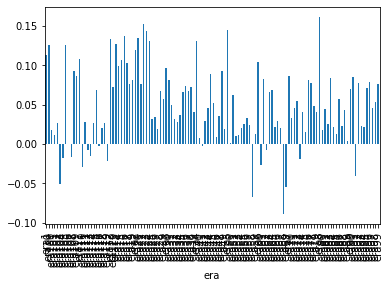

On training the correlation has mean 0.04850678907465003 and std 0.04917732284798404
training performance over time


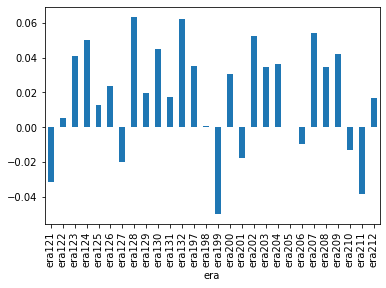

On validation the correlation has mean 0.017752448009834085 andstd 0.031200661164125898
Training split #2
Prediciting split #2
Iter = 2 Mean Squared Error: 0.049829766154289246
training performance over time


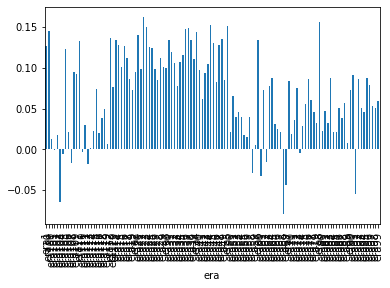

On training the correlation has mean 0.06704929505883486 and std 0.05391331756372889
training performance over time


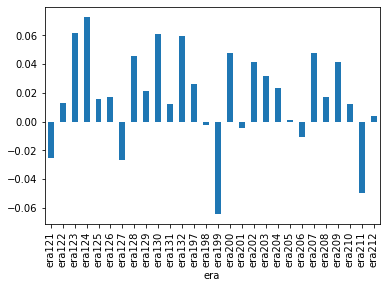

On validation the correlation has mean 0.01746608461649092 andstd 0.033332364381759565
Training split #3
Prediciting split #3
Iter = 3 Mean Squared Error: 0.04976508021354675
training performance over time


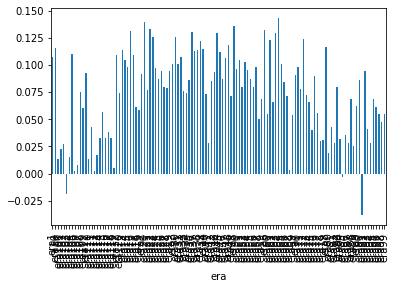

On training the correlation has mean 0.073452391449367 and std 0.03934997897706506
training performance over time


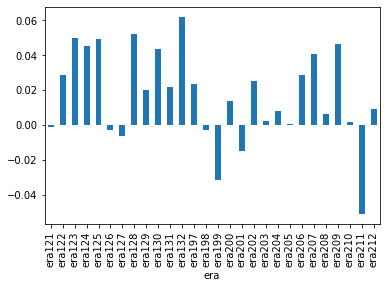

On validation the correlation has mean 0.016755227942090698 andstd 0.02678456668449817
Training split #4
Prediciting split #4
Iter = 4 Mean Squared Error: 0.04980241507291794
training performance over time


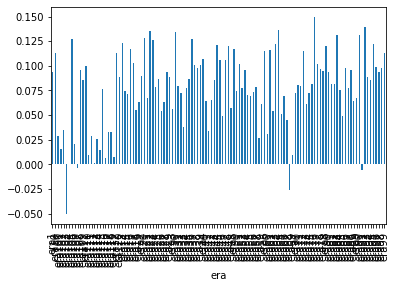

On training the correlation has mean 0.07647001527570968 and std 0.0389328681223044
training performance over time


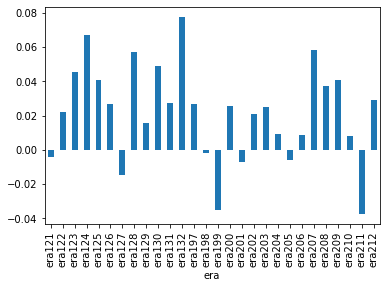

On validation the correlation has mean 0.021868388237308408 andstd 0.0283359822538059


In [ ]:
#hypertuning of xgboost with these selected features
#colab will crash if you attempt to run any more since the size of the data

parameters = {"n_estimators":[25,50,100,200], "learning_rate":[0.5,1,1.5,2], "loss": ["linear", "square", "exponential"]}
xgboost_results = []
xgboost_bestparams = []
feature_names = [f for f in training_data.columns if f.startswith("feature")]
for split, train_test_split in enumerate(get_train_test_splits(training_data)):
    gc.collect()
    train_split, test_split = train_test_split
    lcl_train, lcl_test = training_data.loc[training_data["era"].isin(train_split)], training_data.loc[training_data["era"].isin(test_split)]
    parameters = {"eta":[.01,.005,.001], "max_depth": [2, 3, 5]}
    xgb = xgboost.XGBRegressor(random_state=0, tree_method="gpu_hist", objective="reg:squarederror")
    gridSearchXGBoost = GridSearchCV(xgb, param_grid=parameters)
    print(f'Training split #{split+1}')
    gridSearchXGBoost.fit(lcl_train[feature_names], lcl_train["target"])
    print(f'Prediciting split #{split+1}')
    predictions_adaboost = gridSearchXGBoost.predict(lcl_test[feature_names])
    print(f"Iter = {split+1} Mean Squared Error: {mean_squared_error(lcl_test['target'], predictions_adaboost)}")

    validation_data["predictions"] = gridSearchXGBoost.predict(validation_data[feature_names])
    # Check the per-era correlations on the training set (in sample)
    training_data['predictions'] = gridSearchXGBoost.predict(training_data[feature_names])
    train_correlations = training_data.groupby("era").apply(score)
    train_correlations.plot(kind="bar")
    print("training performance over time")
    plt.show() 
    print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")

    # Check the per-era correlations on the validation set (out of sample)
    validation_correlations = validation_data.groupby("era").apply(score)
    validation_correlations.plot(kind="bar")
    print("training performance over time")
    plt.show() 
    print(f"On validation the correlation has mean {validation_correlations.mean()} and" f"std {validation_correlations.std()}")
    grid_xgb_results = gridSearchXGBoost.cv_results_
    xgboost_results.append(grid_xgb_results)
    xgb_best_params = gridSearchXGBoost.best_params_
    xgboost_bestparams.append(xgb_best_params)

In [ ]:
# best parameters so we will use these
xgboost_bestparams[-1]

{'eta': 0.01, 'max_depth': 3}

In [ ]:
xgb = xgboost.XGBRegressor(random_state=0, tree_method="gpu_hist", objective="reg:squarederror",eta=.01,max_depth=3)

In [ ]:
xgb.fit(training_data[confeats],training_data['target'])

XGBRegressor(eta=0.01, objective='reg:squarederror', tree_method='gpu_hist')

In [ ]:
tournament_data['prediction'] = xgb.predict(tournament_data[confeats])

In [ ]:
# submission
tournament_data['prediction'].to_csv("submission.csv", header=True)
model_id = '' #dbk2
submission_id = napi.upload_predictions("submission.csv", model_id=model_id)

2022-05-30 01:32:34,238 INFO numerapi.base_api: uploading predictions...
